In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import time

In [2]:
Gamma = 22 # Hz to kHz, Decay rate
wavelength = 359.3e-9 # m to mm
k = 1/wavelength*2*np.pi #x_0
x0 = 1/k
t0 = 1/Gamma*1/(2*np.pi*1e6)
v0 = x0/t0
m0 = cts.hbar*t0/x0**2
a0 = x0/t0**2
F0 = cts.hbar/(x0*t0)
mass = 43*cts.value('atomic mass constant')/m0 # m_0
waist = 0.012/x0
v_max = 4
z_max = 0.020/x0
z_start = 0.020/x0
dz = 0.5/x0
dv = 0.5
v_eval = np.arange(1.0,4.0,0.5)
t_eval = np.linspace(0.,4000000.,4000001)
omega = 2*np.pi*(cts.c/wavelength) #Transition frequency
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3

# The detunings used in the PRAs:
P = np.array([0.010, 0.050, 0.1, 0.2])
intensities = 2.*P/(np.pi*(0.012)**2)/Isat
power_index = 2

#Make the axis:
z = np.linspace(0, 20., 101)
v = np.linspace(0., 4., 101)
zz = np.linspace(-1*z_max,z_max+dz,1000)
vv = np.linspace(-1*v_max,v_max+dv,100)
Z,V = np.meshgrid(zz,vv)



H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(B=0,
gamma = 50.697/Gamma,b=154.7/Gamma, c=178.5/Gamma,
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,return_basis=True
    )

# b : SI coupling(isotropic), c : Iz Sz coupling(anisotropic), cc : I N coupling, gamma : S N coupling

E_X = np.unique(np.diag(H0_X))

H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(
    P=+1, Ahfs=-1.5/Gamma, q=0, p=0,gJ=-0.00002,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )

# gJ : Lande g-factor, p : parity(e parity)

E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq,mass = mass)

In [3]:
def Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    pX = (p1+p2+p3+p4)/4
    pp1 = p1 - pX
    pp2 = p2 - pX
    pp3 = p3- pX
    pp4 = p4 - pX
    
    def intensity_res(pp):
        intensity_norm = 0.050
        result = 2.*(intensity_norm+pp/(10**3))/(np.pi*(0.012)**2)/Isat
        return result
    
    def sigmoid_function(x):
        if (1/(1+np.exp(-1*x))*2)//1 == 1.:
            return +1
        else:
            return -1
    
    laserBeams = pylcp.laserBeams()
    for ii, Eg_i in enumerate(E_X):
        if ii<1:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp1), delta=(E_A[-1] - Eg_i)+d1,pol=sigmoid_function(pol1),wb=waist,
                beam_type=pylcp.gaussianBeam
                )
        elif ii==1:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp2), delta=(E_A[-1] - Eg_i)+d2,pol=sigmoid_function(pol2),wb=waist,
                beam_type=pylcp.gaussianBeam)
        elif ii==2:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp3), delta=(E_A[-1] - Eg_i)+d3,pol=sigmoid_function(pol3),wb=waist,
                beam_type=pylcp.gaussianBeam
                )
        else:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp4), delta=(E_A[-1] - Eg_i)+d4,pol=sigmoid_function(pol4),wb=waist,
                beam_type=pylcp.gaussianBeam
                )

    return laserBeams

In [10]:
def magField_func(Bgrad):
    return pylcp.quadrupoleMagneticField(Bgrad*1000*x0)

In [11]:
zz = np.linspace(-1*z_max,z_max+dz,1000)
vv = np.linspace(-1*v_max,v_max+dv,100)
Z,V = np.meshgrid(zz,vv)

In [12]:
laserBeams = Fixed_detune_MgF_MOT(0.14,0.30,-1.77,-2.98,42,16,38,24,0.796,-1.0,1.0,-1.0)
magField = magField_func(2.56)
rateeq = pylcp.rateeq(laserBeams,magField,hamiltonian,include_mag_forces=False)
rateeq.generate_force_profile([Z,np.zeros(Z.shape),np.zeros(Z.shape)],[V,np.zeros(V.shape),np.zeros(V.shape)],name='Fx',progress_bar=1)
rateeq.generate_force_profile([np.zeros(Z.shape),Z,np.zeros(Z.shape)],[np.zeros(V.shape),V,np.zeros(V.shape)],name='Fy',progress_bar=1)

Completed in 2:42.                                                  
Completed in 2:43.                                                  


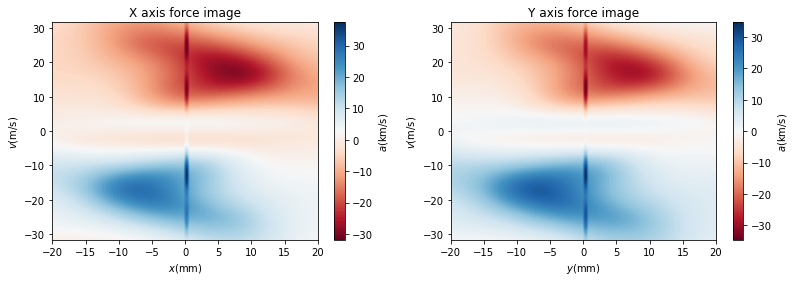

In [19]:
fig, ax = plt.subplots(1, 2,figsize=(13,4))

imx = ax[0].imshow(rateeq.profile['Fx'].F[0]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
imy = ax[1].imshow(rateeq.profile['Fy'].F[1]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
cbx = plt.colorbar(imx,ax = ax[0])
cby = plt.colorbar(imy,ax = ax[1])

cbx.set_label('$a (\mathrm{km/s})$')
cby.set_label('$a (\mathrm{km/s})$')

ax[0].set_xlabel('$x (\mathrm{mm})$')
ax[0].set_ylabel('$v (\mathrm{m/s})$')
ax[0].set_title('X axis force image')
ax[0].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
ax[0].set_ylim(-1*v_max*v0,v_max*v0)
ax[1].set_xlabel('$y (\mathrm{mm})$')
ax[1].set_ylabel('$v (\mathrm{m/s})$')
ax[1].set_title('Y axis force image')
ax[1].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
ax[1].set_ylim(-1*v_max*v0,1*v_max*v0)
fig.subplots_adjust(left=0.12,right=0.9)

fig.savefig('./picture/Maxplot.png')

In [14]:
# See solve_ivp documentation for event function discussion:
def captured_condition(t, y, threshold=5e-2):
    if(y[-6]<threshold and y[-5]<threshold):
        val = -1.
    else:
        val = 1.

    return val

def lost_condition(t, y, threshold=4.5):
    if y[-6]>threshold or y[-5]>threshold:
        val = -1.
    else:
        val = 1.

    return val

captured_condition.terminal=True
lost_condition.terminal = True
conditions =  [captured_condition,lost_condition]

In [15]:
sols_rate = list()

start = time.time()

for v0a in v_eval:
    rateeq.set_initial_position_and_velocity(np.array([-1*z_start,-1*z_start,0]),np.array([v0a,v0a,0.]))
    rateeq.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))
    
    rateeq.evolve_motion([0.,max(t_eval)],events = conditions ,progress_bar = 1,t_eval=t_eval,max_step=np.inf,method='LSODA')
    sols_rate.append(rateeq.sol)

Completed in 10.76 s.                                                
Completed in 9.96 s.                                                 
Completed in 9.77 s.                                                 
Completed in 9.98 s.                                                
Completed in 9.48 s.                                                 
Completed in 9.56 s.                                                


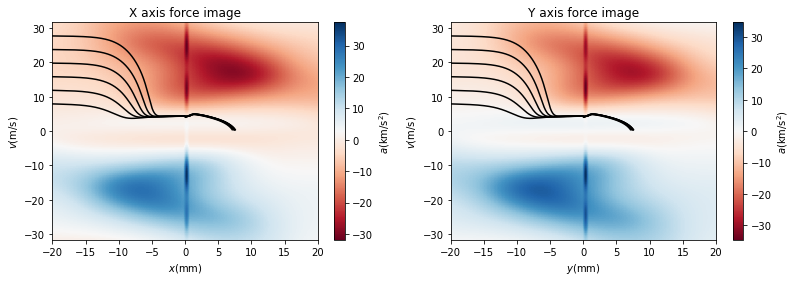

In [17]:
fig, ax = plt.subplots(1, 2,figsize=(13,4))

imx = ax[0].imshow(rateeq.profile['Fx'].F[0]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
imy = ax[1].imshow(rateeq.profile['Fy'].F[1]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
cbx = plt.colorbar(imx,ax = ax[0])
cby = plt.colorbar(imy,ax = ax[1])

cbx.set_label('$a (\mathrm{km/s^2})$')
cby.set_label('$a (\mathrm{km/s^2})$')

ax[0].set_xlabel('$x (\mathrm{mm})$')
ax[0].set_ylabel('$v (\mathrm{m/s})$')
ax[0].set_title('X axis force image')
ax[0].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
ax[0].set_ylim(-1*v_max*v0,v_max*v0)
ax[1].set_xlabel('$y (\mathrm{mm})$')
ax[1].set_ylabel('$v (\mathrm{m/s})$')
ax[1].set_title('Y axis force image')
ax[1].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
ax[1].set_ylim(-1*v_max*v0,1*v_max*v0)
fig.subplots_adjust(left=0.12,right=0.9)

for sol in sols_rate:
    ax[0].plot(sol.r[0]*x0*1000,sol.v[0]*v0,'k')
    ax[1].plot(sol.r[1]*x0*1000,sol.v[1]*v0,'k')

fig.savefig('./picture/Maximum.png')

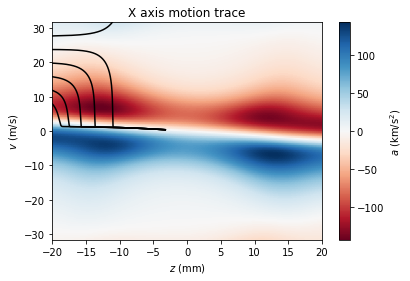

In [9]:
fig, ax = plt.subplots(1, 1)
plt.imshow(rateeq.profile['Fx'].F[0]/mass*1e-3*a0, origin='lower',
           extent=(np.amin(zz*1000*x0), np.amax(zz*1000*x0),
                   (np.amin(vv*v0)), (np.amax(vv*v0))),
           aspect='auto',cmap='RdBu')
cb1 = plt.colorbar()
cb1.set_label('$a\ (\mathrm{km/s^2})$')
ax.set_xlabel('$z\ (\mathrm{mm})$')
ax.set_ylabel('$v\ (\mathrm{m/s})$')
ax.set_title('X axis motion trace')
ax.set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
ax.set_ylim(-1*v_max*v0,v_max*v0)
fig.subplots_adjust(left=0.12,right=0.9)

for sol in sols_rate:
    ax.plot(sol.r[0]*x0*1000,sol.v[0]*v0,'k')

fig.savefig('./picture/20210614_11.png')

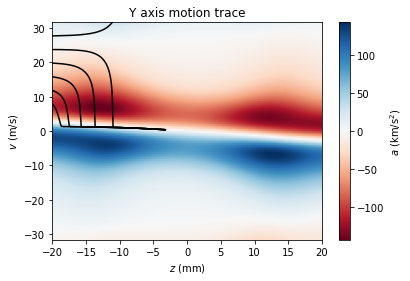

In [10]:
fig, ax = plt.subplots(1, 1)
plt.imshow(rateeq.profile['Fy'].F[1]/mass*1e-3*a0, origin='lower',
           extent=(np.amin(zz*1000*x0), np.amax(zz*1000*x0),
                   (np.amin(vv*v0)), (np.amax(vv*v0))),
           aspect='auto',cmap='RdBu')
cb1 = plt.colorbar()
cb1.set_label('$a\ (\mathrm{km/s^2})$')
ax.set_xlabel('$z\ (\mathrm{mm})$')
ax.set_ylabel('$v\ (\mathrm{m/s})$')
ax.set_title('Y axis motion trace')
ax.set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
ax.set_ylim(-1*v_max*v0,v_max*v0)
fig.subplots_adjust(left=0.12,right=0.9)

for sol in sols_rate:
    ax.plot(sol.r[1]*x0*1000,sol.v[1]*v0,'k')

fig.savefig('./picture/20210614_12.png')

In [11]:
# for sol in sols_rate:
#     if len(sol.t_events[0])==1:
#         print('completely trapped')
#     elif len(sol.t_events[1])==1:
#         print('lost')
#     else:
#         print('i don`t know')

In [12]:
# sols = sols_rate[0]

# fig, ax = plt.subplots(3,1,figsize=(5,12))
# ax[0].set_title('Accererationvs t')
# ax[1].set_title('Velocity vs t')
# ax[2].set_title('Position vs t')
# ax[0].plot(sols.t,sols.F[0]/mass)
# ax[1].plot(sols.t,sols.v[0])
# ax[2].plot(sols.t,sols.r[0])
# ax[0].set_ylabel('$a (\mathrm{\Gamma^2/k})$')
# ax[1].set_ylabel('$v (\mathrm{\Gamma/k})$')
# ax[2].set_ylabel('$x (\mathrm{1/k})$')
# ax[2].set_xlabel('time $t\Gamma$')

# for i in range(3):
#     ax[i].grid()

# fig.suptitle('a,v,x vs t')

# fig.savefig('./picture/20210529_2.png')

In [13]:
# sols = sols_rate[-1]

# fig, ax = plt.subplots(3,1,figsize=(5,12))
# ax[0].set_title('Accererationvs t')
# ax[1].set_title('Velocity vs t')
# ax[2].set_title('Position vs t')
# ax[0].plot(sols.t,sols.F[1]/mass)
# ax[1].plot(sols.t,sols.v[1])
# ax[2].plot(sols.t,sols.r[1])
# ax[0].set_ylabel('$a (\mathrm{\Gamma^2/k})$')
# ax[1].set_ylabel('$v (\mathrm{\Gamma/k})$')
# ax[2].set_ylabel('$x (\mathrm{1/k})$')
# ax[2].set_xlabel('time $t\Gamma$')

# for i in range(3):
#     ax[i].grid()

# fig.suptitle('Lost atom')

# # fig.savefig('./picture/20210529_3.png')

In [14]:
# test.savefig('20210416_7')

In [15]:
def is_trapped(v0,z0,eqn, captured_condition, lost_condition, tmax=1000, max_step=np.inf, **kwargs):
    eqn.set_initial_position_and_velocity(np.array([z0,z0,0.]),np.array([v0,v0,0.]))
    if isinstance(eqn,pylcp.rateeq):
        eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))
    time_ev = np.linspace(0,tmax,tmax+1)
    
    eqn.evolve_motion([0.,tmax],t_eval=time_ev,events = [captured_condition,lost_condition],max_step = max_step,method='LSODA')
    
    if len(eqn.sol.t_events[0]) == 1:
        return 1
    else:
        return -1

In [16]:
from scipy.optimize import root_scalar
start = time.time()
vc = root_scalar(is_trapped,bracket=[2.5,3.5],args = (-1*z_start,rateeq,captured_condition,lost_condition,2000000),method = 'brentq')

vc

      converged: True
           flag: 'converged'
 function_calls: 41
     iterations: 40
           root: 3.2750663634815282

In [17]:
print(time.time()-start)

226.10272073745728


0.050000026564705036


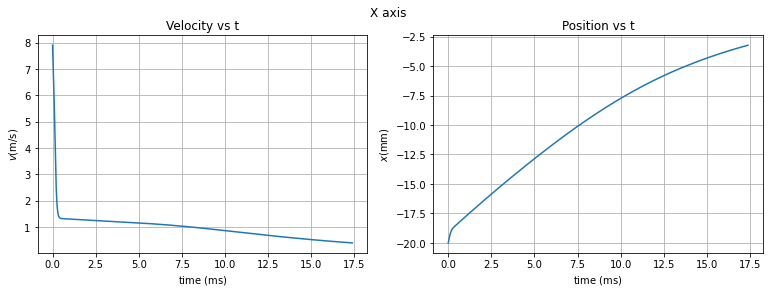

In [18]:
sols = sols_rate[0]
fig, ax = plt.subplots(1,2,figsize=(13,4))

ax[0].set_title('Velocity vs t')
ax[1].set_title('Position vs t')

ax[0].plot(sols.t*t0*1000,sols.v[0]*v0)
ax[1].plot(sols.t*t0*1000,sols.r[0]*1000*x0)

ax[0].set_ylabel('$v (\mathrm{m/s})$')
ax[0].set_xlabel('time $(\mathrm{ms})$')
ax[1].set_ylabel('$x (\mathrm{mm})$')
ax[1].set_xlabel('time $(\mathrm{ms})$')

fig.suptitle('X axis')

for i in range(2):
    ax[i].grid()
    
print(sols.v[0][-1])

fig.savefig('./picture/50mW_trap_xy.png')

4.49992195012834


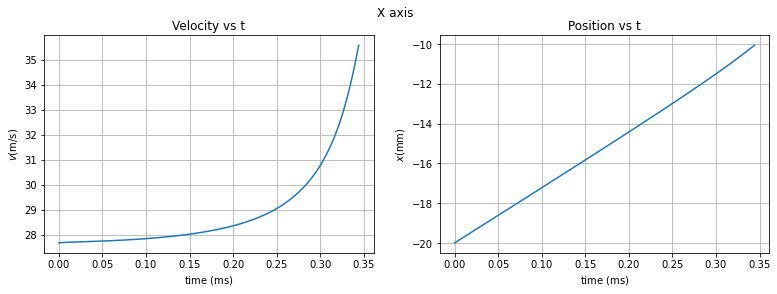

In [19]:
sols = sols_rate[-1]
fig, ax = plt.subplots(1,2,figsize=(13,4))

ax[0].set_title('Velocity vs t')
ax[1].set_title('Position vs t')

ax[0].plot(sols.t*t0*1000,sols.v[0]*v0)
ax[1].plot(sols.t*t0*1000,sols.r[0]*1000*x0)

ax[0].set_ylabel('$v (\mathrm{m/s})$')
ax[0].set_xlabel('time $(\mathrm{ms})$')
ax[1].set_ylabel('$x (\mathrm{mm})$')
ax[1].set_xlabel('time $(\mathrm{ms})$')

fig.suptitle('X axis')

for i in range(2):
    ax[i].grid()
    
print(sols.v[0][-1])
fig.savefig('./picture/50mW_lost_xy.png')

0.050000040482836704


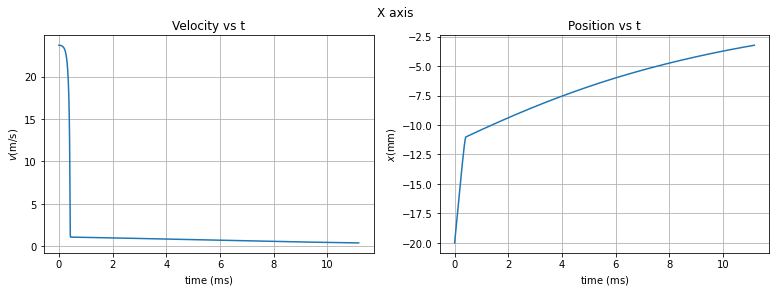

In [20]:
sols = sols_rate[-2]
fig, ax = plt.subplots(1,2,figsize=(13,4))

ax[0].set_title('Velocity vs t')
ax[1].set_title('Position vs t')

ax[0].plot(sols.t*t0*1000,sols.v[0]*v0)
ax[1].plot(sols.t*t0*1000,sols.r[0]*1000*x0)

ax[0].set_ylabel('$v (\mathrm{m/s})$')
ax[0].set_xlabel('time $(\mathrm{ms})$')
ax[1].set_ylabel('$x (\mathrm{mm})$')
ax[1].set_xlabel('time $(\mathrm{ms})$')

fig.suptitle('X axis')

for i in range(2):
    ax[i].grid()
    
print(sols.v[0][-1])
fig.savefig('./picture/20210614_10.png')